### Implementation of your own block matching algorithm for stereo depth reconstruction. 


You are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries

1. Implement a function that takes two equal size images and calculates the sum of absolute differences. The two equal-sized images are nose_left.png (used as the template) and nose_right.png.

2. Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

3. Since these images are rectified, we can approximately assume that a pixel found in row x in the left image also lives in row x in the right image. nose_span.png contains the entire row containing the nose of the sculpture. The height of the span is 7 - the same height as your template. Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.


In [32]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.gray()

<Figure size 432x288 with 0 Axes>

## Initial images

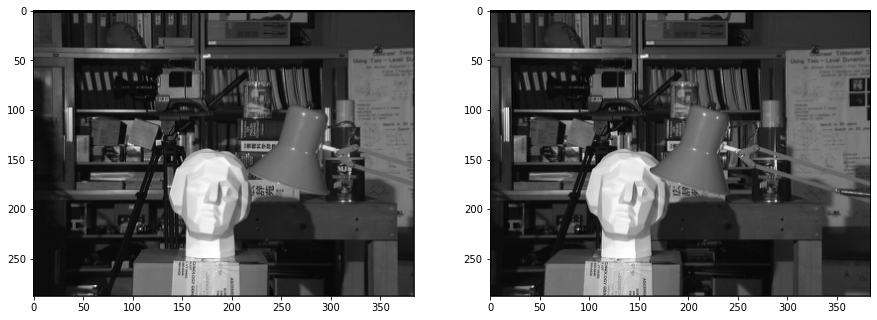

In [33]:
img_left = cv2.imread("tsukuba_left.png")
img_right = cv2.imread("tsukuba_right.png")

img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)

img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
gray_right= cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(gray_left)
axarr[1].imshow(gray_right)

## Noses

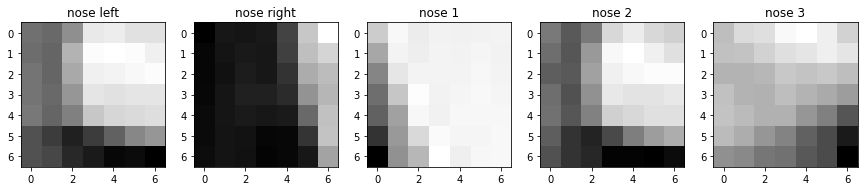

In [34]:
nose_left = cv2.imread("nose_left.png")
nose_right = cv2.imread("nose_right.png")
noses = [cv2.imread("nose1.png"), cv2.imread("nose2.png"), cv2.imread("nose3.png")]

nose_left = cv2.cvtColor(nose_left, cv2.COLOR_BGR2RGB)
nose_gray_left = cv2.cvtColor(nose_left, cv2.COLOR_RGB2GRAY)

nose_right = cv2.cvtColor(nose_right, cv2.COLOR_BGR2RGB)
nose_gray_right= cv2.cvtColor(nose_right, cv2.COLOR_RGB2GRAY)

noses_gray = []
for i, nose in enumerate(noses):
    nose = cv2.cvtColor(nose, cv2.COLOR_BGR2RGB)
    noses_gray.append(cv2.cvtColor(nose, cv2.COLOR_RGB2GRAY))
    
f, axarr = plt.subplots(1,5, figsize = (15,15))
axarr[0].imshow(nose_gray_left)
axarr[0].set_title("nose left")
axarr[1].imshow(nose_gray_right)
axarr[1].set_title("nose right")
for i, nose in enumerate(noses_gray):
    axarr[2+i].imshow(nose)
    axarr[2+i].set_title(f"nose {i+1}")
    

## Absolute differences

In [35]:
def absoluteDifference(img1, img2):
    diff = cv2.absdiff(img1, img2)
    return diff

def SAD(img1, img2):
    return np.sum(absoluteDifference(img1, img2))

print(absoluteDifference(gray_left, gray_right))

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 2 1]
 ...
 [0 1 3 ... 0 4 3]
 [1 1 1 ... 6 2 2]
 [1 1 1 ... 7 1 0]]


## Best match for nose left

In [36]:
diff = [SAD(nose_gray_left, nose) for nose in noses_gray]
print(f"Best matching image: nose {np.argmin(diff)+1}")

Best matching image: nose 2


## Span best SAD

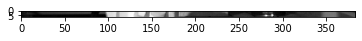

In [37]:
nose_span = cv2.imread("nose_span.png")

nose_span = cv2.cvtColor(nose_span, cv2.COLOR_BGR2RGB)
nose_span_gray = cv2.cvtColor(nose_span, cv2.COLOR_RGB2GRAY)

plt.imshow(nose_span_gray)
plt.figsize = (15,15)

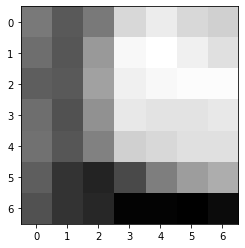

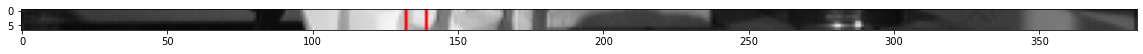

In [65]:


def findBestInRow(match, span, column, scope):
    kernel_size =  len(match[0]), len(match)
    span_size = len(span[0]), len(span),
    best_score = float("inf")
    best_start = -1
    start_range = column - scope*kernel_size[0] if column - scope*kernel_size[0] > 0 else 0
    end_range = column+ scope*kernel_size[0] if column+ scope*kernel_size[0] < span_size[0] - kernel_size[0] else span_size[0] - kernel_size[0] + 1
    for start in range(start_range, end_range): #span_size[0] - kernel_size[0] + 1):
        kernel = span[:, start:start+kernel_size[0]]
        score = SAD(match, kernel)
        if  score < best_score:
            best_score = score
            best_start = start
            
    return best_start, best_score  
    
best_start, best_score = findBestInRow(nose_gray_left, nose_span_gray, 180, 10)
    
kernel_size =  len(nose_gray_left[0]), len(nose_gray_left)
where_is_nose = nose_span_gray[:, best_start:best_start+kernel_size[0]]
plt.imshow(where_is_nose)
plt.figsize = (15,15)

where_is_nose = cv2.rectangle(nose_span.copy(), (best_start, -1), (best_start+kernel_size[0],kernel_size[1]+1), (255,0,0), 1)
plt.figure(figsize = (20,100))
plt.imshow(where_is_nose)


In [119]:
kernel_size = (15,15)
scope = 5
best_starts = []
for row in range(len(gray_left) - kernel_size[1] + 1):
    best_starts.append([])
    for column in range(len(gray_left[0]) - kernel_size[0] + 1):
        kernel = gray_left[row:row+kernel_size[1], column:column+kernel_size[0]]
        best_start, best_score = findBestInRow(kernel, gray_right[row:row+kernel_size[1], :], column, scope)
        best_starts[row].append((best_start, best_score))
    
#print(best_starts)

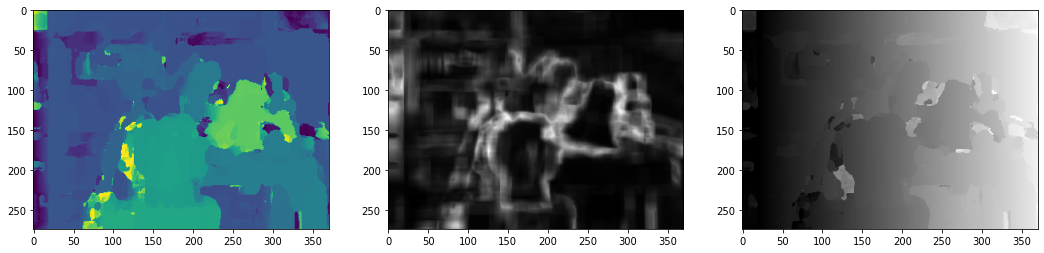

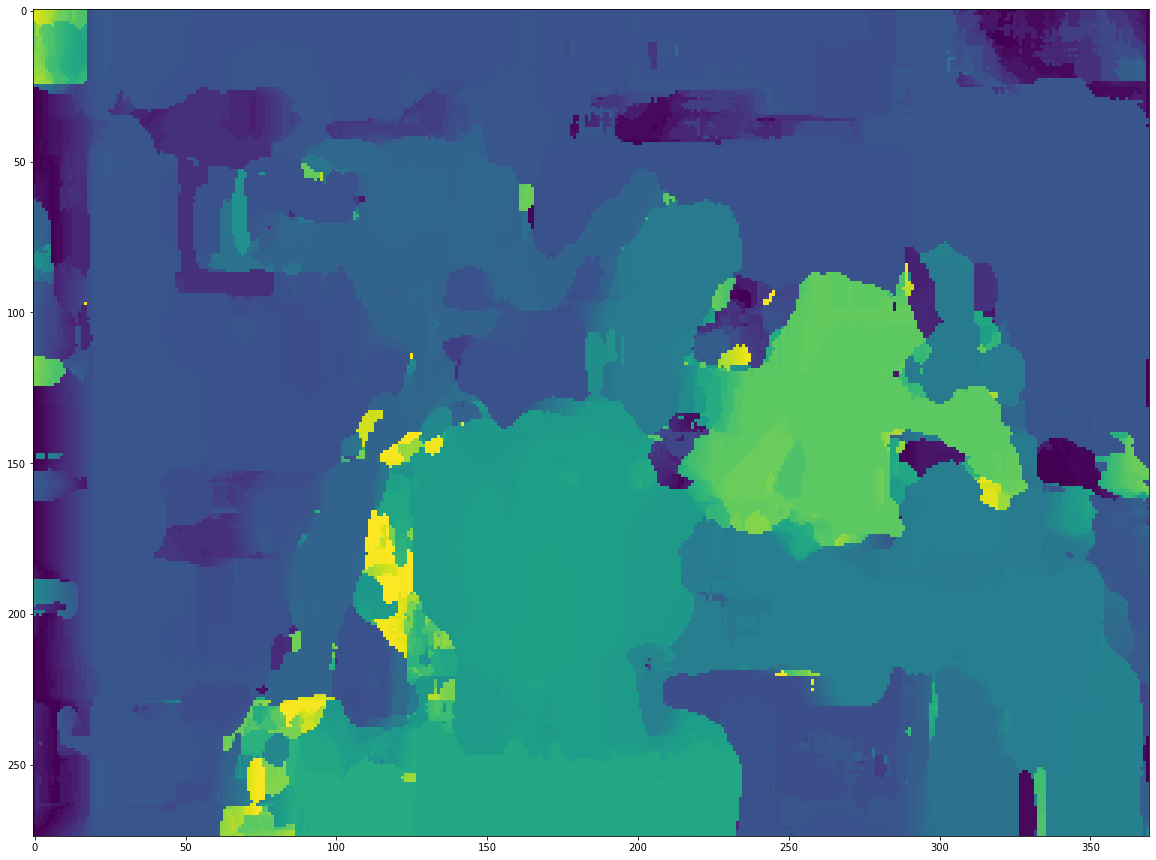

In [126]:
best_starts = np.array(best_starts)
gray_left_cropped = gray_left[0:len(gray_left) - kernel_size[0] + 1, 0:len(gray_left[1]) - kernel_size[1]+1]

gray_left_cropped_ind = np.zeros_like(gray_left_cropped).astype("int16")
for i in range(len(gray_left_cropped_ind)):
    for j in range(len(gray_left_cropped_ind[0])):
        gray_left_cropped_ind[i,j] = j

disparity = cv2.absdiff(gray_left_cropped_ind.astype("int16"), best_starts[:,:,0].astype("int16"))        

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,18))
ax[0].imshow(disparity,cmap="viridis")
ax[1].imshow(best_starts[:,:, 1])
ax[2].imshow(best_starts[:,:,0])

plt.figure(figsize=(20,20))
plt.imshow(disparity,cmap="viridis")
